In [ ]:
import tensorflow as tf
from modules.metropolis import *
import numpy as np
import matplotlib.pyplot as plt

@dataclass
class SimpleProblem(QFTProblem):
    size: tuple[float, float] = (10, 100)

    def volume(self) -> npt.NDArray:
        return np.array(self.size).reshape((1, 2))

    def get_amplitude(self, x_n: tf.Tensor) -> tf.Tensor:
        profile = tf.pow(tf.reduce_prod(tf.sin(x_n[:, :, 0]) * tf.sin(x_n[:, :, 1] / 20), axis = 1), 2)

        return profile * np.exp(-x_n.shape[1] / 10.) / np.power(np.prod(self.volume()), x_n.shape[1] / 2.) * (0.1 + x_n.shape[1])

In [101]:
test_problem = SimpleProblem()

metropolis = FockSpaceMetropolis(test_problem, rng=np.random.default_rng(0))

x_n = metropolis.new_configuration(5)
print("initial\n", x_n)

x_add = metropolis.add_new(x_n)
print("add new\n", x_add)

x_remove = metropolis.remove_one(x_n)
print("remove one\n", x_remove)
            
x_changed = metropolis.change_positions(x_n)
print("change position\n", x_changed)

x_changed = metropolis.change_positions(x_n)
print("change position\n", x_changed)

x_n = metropolis.new_configuration(0)
print("initial\n", x_n)

x_remove = metropolis.remove_one(x_n)
print("remove one\n", x_remove)

x_add = metropolis.add_new(x_n)
print("add new\n", x_add)

initial
 [[ 6.36961687 26.97867138]
 [ 0.40973524  1.65276355]
 [ 8.13270239 91.27555773]
 [ 6.06635776 72.9496561 ]
 [ 5.43624991 93.50724238]]
add new
 [[ 6.36961687 26.97867138]
 [ 0.40973524  1.65276355]
 [ 8.13270239 91.27555773]
 [ 6.06635776 72.9496561 ]
 [ 5.43624991 93.50724238]
 [ 8.15853536  0.27385002]]
remove one
 [[ 6.36961687 26.97867138]
 [ 8.13270239 91.27555773]
 [ 6.06635776 72.9496561 ]
 [ 5.43624991 93.50724238]]
change position
 [[ 1.70547263 49.94421602]
 [ 7.16629145 37.97065579]
 [ 8.54731459 71.24674678]
 [ 5.29322997 25.78162321]
 [ 1.67908268 10.56968385]]
change position
 [[ 7.84151199 38.51718252]
 [ 9.24651078 51.37375713]
 [ 2.94105578  9.82975618]
 [ 7.57095052 91.79432916]
 [ 4.32546415 57.01689288]]
initial
 []
remove one
 None
add new
 [[ 7.21488357 52.53543258]]


In [102]:
x_recent = metropolis.new_configuration(5)
configurations = [x_recent]
for _ in range(10000):
    result = metropolis.step(x_recent)
    if result is None:
        continue

    x_recent = result
    configurations.append(x_recent)

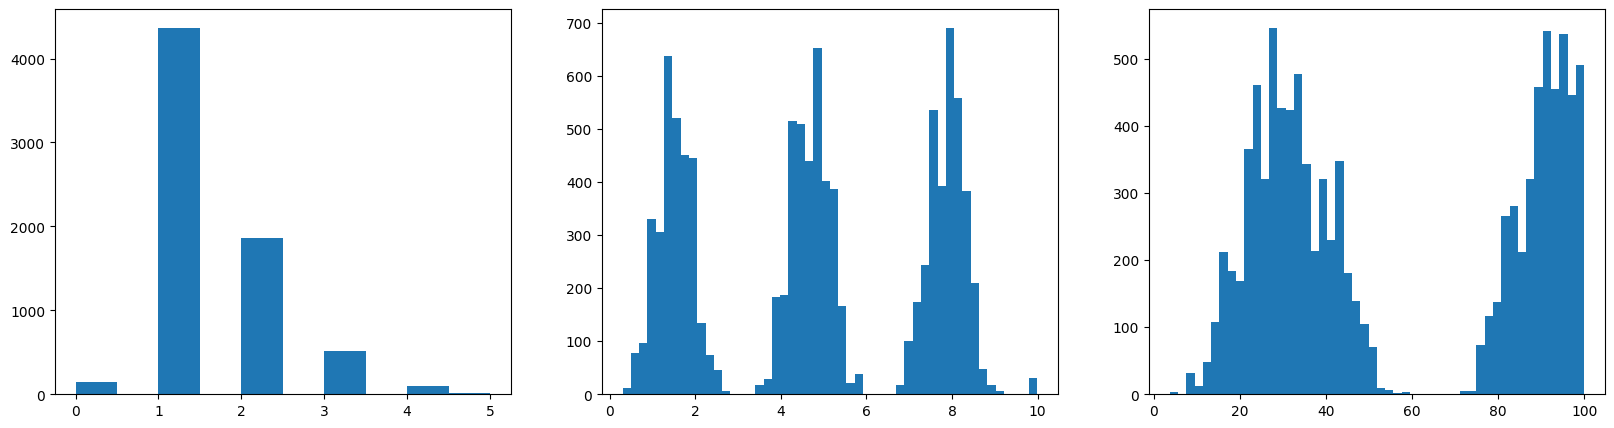

In [103]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

skip = int(0.3 * len(configurations))

configurations = configurations[skip:]

n_values = list(map(lambda x: x.shape[0], configurations))
axes[0].hist(n_values) # type: ignore

positions_1 = np.concatenate(list(map(lambda x: x[:, 0], configurations))).ravel()
positions_2 = np.concatenate(list(map(lambda x: x[:, 1], configurations))).ravel()

axes[1].hist(positions_1, bins=50) # type: ignore
axes[2].hist(positions_2, bins=50); # type: ignore

In [104]:
with tf.GradientTape() as g2:
    with tf.GradientTape() as g:
        x_n = tf.expand_dims(tf.Variable(configurations[20]), axis=0)
        print(x_n)

        value = test_problem.get_amplitude(x_n)

    gradient = g.gradient(value, x_n)

hessian = g2.jacobian(gradient, x_n)
# laplacian = tf.linalg.trace(laplacian)
laplacian = tf.einsum('bpibpi->bpi', hessian)

print("y", value)
print("gradient", gradient)
print("laplacian", laplacian)

tf.Tensor([[[ 4.85924769 23.90258908]]], shape=(1, 1, 2), dtype=float64)
y tf.Tensor([0.02665474], shape=(1,), dtype=float64)
gradient tf.Tensor([[[-0.00788573  0.00105125]]], shape=(1, 1, 2), dtype=float64)
laplacian tf.Tensor([[[-0.05214298 -0.00011254]]], shape=(1, 1, 2), dtype=float64)


In [105]:
x0 = 4.85924769
x1 = 23.90258908

print("y", np.power(np.sin(x0) * np.sin(x1 / 20), 2) * np.exp(-0.1) / np.sqrt(1000) * 1.1)
print("dy/dx0", np.sin(2 * x0) * np.sin(x1 / 20) ** 2 * np.exp(-0.1) / np.sqrt(1000) * 1.1)
print("dy/dx1", 1 / 20 * np.sin(x0) ** 2 * np.sin(2 * x1 / 20) * np.exp(-0.1) / np.sqrt(1000) * 1.1)
print("d^2y/dx0^2", 2 * np.cos(2 * x0) * np.sin(x1 / 20) ** 2 * np.exp(-0.1) / np.sqrt(1000) * 1.1)
print("d^2y/dx1^2", 1 / 200 * np.sin(x0) ** 2 * np.cos(2 * x1 / 20) * np.exp(-0.1) / np.sqrt(1000) * 1.1)

y 0.026654735548713143
dy/dx0 -0.007885733618981039
dy/dx1 0.0010512547138865212
d^2y/dx0^2 -0.05214298429068455
d^2y/dx1^2 -0.00011254309365187722


In [107]:
from importlib import reload
import modules.hamiltonians.hamiltonian_terms as terms
reload(terms)

kinetic_term = terms.KineticTerm(0.5)

print(x_n)

print("kinetic term")
print(kinetic_term.local_energy(x_n, test_problem))

chemical_potential = terms.ExternalPotential.chemical_potential(1)

print("Chemical potential")
print(chemical_potential.local_energy(x_n, test_problem))

tf.Tensor([[[ 4.85924769 23.90258908]]], shape=(1, 1, 2), dtype=float64)
kinetic term
tf.Tensor(1.9604594187861322, shape=(), dtype=float64)
Chemical potential
tf.Tensor([[1.]], shape=(1, 1), dtype=float32)
